In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier


def evaluate_all(y_true, proba, threshold=0.5):
    y_pred = (proba >= threshold).astype(int)
    return {
        "ROC-AUC": roc_auc_score(y_true, proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
    }

In [4]:
TRAIN_PATH = "DATA/preprocessed_train.csv"
VALID_PATH = "DATA/preprocessed_valid.csv"
TEST_PATH  = "DATA/preprocessed_test.csv"

In [5]:
df_tr = pd.read_csv(TRAIN_PATH)
df_va = pd.read_csv(VALID_PATH)
df_te = pd.read_csv(TEST_PATH)

In [6]:
df_tr.head()

,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,ID
0,37200,3,4.0,6,1,9000,0,0.24,1,6,23482
1,83000,3,0.0,2,4,14000,1,0.17,2,4,14094
2,50000,3,1.0,5,1,4000,0,0.08,1,2,3966
3,43200,2,4.0,1,1,6350,0,0.15,1,4,5052
4,70000,3,6.0,3,4,12000,0,0.17,2,5,25312


In [12]:
df_tr.shape


(20745, 11)

In [15]:
TARGET = "loan_status"
ID_COL = "ID"

X_tr = df_tr.drop(columns=[TARGET, ID_COL])
y_tr = df_tr[TARGET]

X_va = df_va.drop(columns=[TARGET, ID_COL])
y_va = df_va[TARGET]  

X_te = df_te.drop(columns=[TARGET, ID_COL])
y_te = df_te[TARGET]


pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
scale_pos_weight = neg / max(pos, 1)  

xgb_model = XGBClassifier(
    n_estimators=2000,        
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",    
    scale_pos_weight=scale_pos_weight
)




In [ ]:
# --- 5) Eğitim (early stopping ile) ---
xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    verbose=False,
    early_stopping_rounds=100
)
proba_va = xgb_model.predict_proba(X_va)[:, 1]
y_pred  = (proba_va >= 0.5).astype(int)

metrics_va = {
    "ROC-AUC": roc_auc_score(y_va, proba_va),
    "Accuracy": accuracy_score(y_va, y_pred),
    "Precision": precision_score(y_va, y_pred, zero_division=0),
    "Recall": recall_score(y_va, y_pred, zero_division=0),
    "F1": f1_score(y_va, y_pred, zero_division=0),
}
print(metrics_va)

/Users/sezermezgil/anaconda3/envs/tf_m1/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'ROC-AUC': 0.9499373416936785, 'Accuracy': 0.9267399267399268, 'Precision': 0.845861084681256, 'Recall': 0.8030713640469738, 'F1': 0.8239110287303059}


In [29]:
proba_te = xgb_model.predict_proba(X_te)[:, 1]
y_pred  = (proba_te >= 0.47).astype(int)

metrics_te = {
    "ROC-AUC": roc_auc_score(y_te, proba_te),
    "Accuracy": accuracy_score(y_te, y_pred),
    "Precision": precision_score(y_te, y_pred, zero_division=0),
    "Recall": recall_score(y_te, y_pred, zero_division=0),
    "F1": f1_score(y_te, y_pred, zero_division=0),
}
print(metrics_te)

{'ROC-AUC': 0.9440230745921733, 'Accuracy': 0.9142504626773597, 'Precision': 0.8051391862955032, 'Recall': 0.7994330262225372, 'F1': 0.802275960170697}


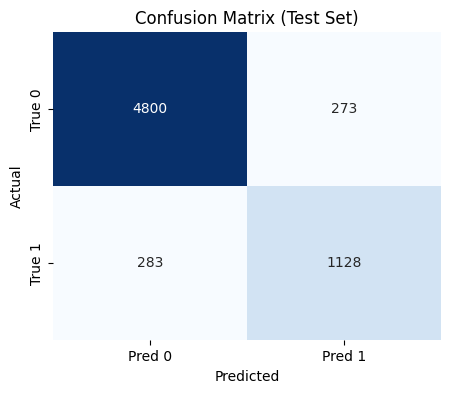

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()